In [72]:
import numpy as np
from scipy import linalg
from scipy import optimize
import matplotlib.pyplot as plt

In [73]:
# dark mode
plt.style.use('dark_background')

In [74]:
no_iter = 10

In [75]:
# Defining constants
A_out = 201.4 # Wm^-2
B_out = 1.45 # Wm^-2C^-1
D = 0.3 # Wm^-2K^-1 For now. It is a tuning coefficient, so that we end up with a reasonable value of x_s
B = B_out/D
Q = 1360/4 # Wm^-2
S_2 = -0.477
a_u = 0.38 # if x > x_s
a_l = 0.68 # if x < x_s

In [76]:
# Legendre polynomials
P_0 = 1
P_0_deriv = 0
P_2 = lambda x: 0.5*(3*x**2 - 1)
P_2_deriv = lambda x: 3*x

In [77]:
# ⚠️ Are the derivatives correct? Especially T_3_deriv

def T_1(x):
    sum = 1
    for i in range(1, no_iter):
        numerator = 1
        denominator = 1
        for j in range(1, i+1):
            numerator *= (B + (2*j-1)*(2*j-2))
            denominator *= 2*j
        sum += (numerator/denominator)*x**(2*i)
    return sum

def T_1_deriv(x):
    sum = 0
    for i in range(1, no_iter):
        numerator = 1
        denominator = 1
        for j in range(1, i+1):
            numerator *= (B + (2*j-1)*(2*j-2))
            denominator *= (2*j - 1)
        sum += (numerator/denominator)*x**(2*i-1)
    return sum

def T_3(x):
    sum = 1
    for i in range(1, no_iter):
        numerator = 1
        denominator = 1
        for j in range(1, i+1):
            numerator *= (B + j*(j-1))
            denominator *= (2*j**2)
        sum += (numerator/denominator)*(1-x)**i
    return sum

def T_3_deriv(x):
    sum = 0
    for i in range(1, no_iter):
        numerator = 1
        denominator = 1
        for j in range(1, i+1):
            numerator *= (B + j*(j-1))
            denominator *= (2*j)
        sum += (numerator/denominator)*(1-x)**(i-1)
    return sum

In [78]:
def T_pu_min_T_pl(x):
    return (a_u-a_l)*P_0/B + Q*S_2*(a_u-a_l)*P_2(x)/(6*B)

def T_pu_min_T_pl_deriv(x):
    return Q*S_2*(a_u-a_l)*P_2_deriv(x)/(6*B)

In [79]:
# Now define the system of equations to be solved by linalg.solve
A = lambda x: np.array([[T_1(x), -T_3(x)], [T_1_deriv(x), -T_3_deriv(x)]])
b = lambda x: np.array([T_pu_min_T_pl(x), T_pu_min_T_pl_deriv(x)])

# Now solve the system for alpha and beta
x_s = 0.2
alpha0, beta0 = linalg.solve(A(x_s), b(x_s))
print(alpha0, beta0)

-0.7271762557714684 -0.001224963861404911


In [80]:
print(Q)

340.0


In [81]:
# Solving for Q
def Q_func(x):
    return (A_out/B)/(beta0*T_3(x) + (a_u/B)*(1+(S_2/6)))

print(Q_func(x_s))

632.8668175951208


Text(0, 0.5, 'Q')

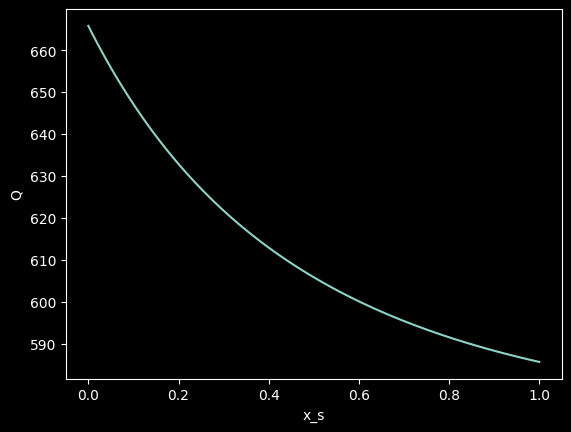

In [82]:
x_s_lst = np.linspace(0, 1, 100)
Q_lst = [Q_func(x) for x in x_s_lst]

plt.plot(x_s_lst, Q_lst)
plt.xlabel('x_s')
plt.ylabel('Q')
# make y axis from min max of Q_lst
# make y axis not log scale
# plt.yscale('linear')
# plt.ticklabel_format(style='plain', axis='y', useOffset=False)
# plt.ticklabel_format(style='plain', axis='y')
# plt.gca().get_yaxis().get_offset_text().set_visible(False)

C:\Users\rannu\AppData\Local\Temp\ipykernel_4020\1635294266.py:7: LinAlgWarning: Ill-conditioned matrix (rcond=8.24611e-21): result may not be accurate.
  alpha0, beta0 = linalg.solve(A(x_s), b(x_s))


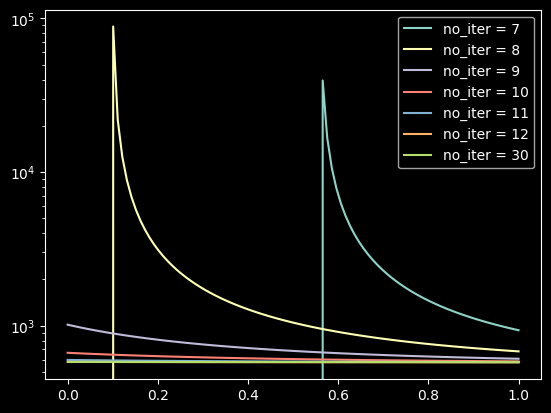

In [83]:
# do a similar plot but plot different solutions for differen no_iter
no_iter_lst = [7, 8, 9, 10, 11, 12, 30]
Q_lst_lst = []
for no_iter in no_iter_lst:
    A = lambda x: np.array([[T_1(x), -T_3(x)], [T_1_deriv(x), -T_3_deriv(x)]])
    b = lambda x: np.array([T_pu_min_T_pl(x), T_pu_min_T_pl_deriv(x)])
    alpha0, beta0 = linalg.solve(A(x_s), b(x_s))
    Q_func = lambda x: (A_out/B)/(beta0*T_3(x) + (a_u/B)*(1+(S_2/6)))
    Q_lst = [Q_func(x) for x in x_s_lst]
    Q_lst_lst.append(Q_lst)

for i in range(len(no_iter_lst)):
    plt.plot(x_s_lst, Q_lst_lst[i], label=f'no_iter = {no_iter_lst[i]}')
plt.legend()
plt.yscale('log')
plt.show()

In [84]:
def f(x, Q): # Function to find the root of
    return Q_func(x) - Q

def x_s_func(Q, x_0 = 0.5): # x_0 is initial guess
    soln = optimize.root(f, x_0, args=(Q,), method = "lm")
    return soln["x"][0]

print(x_s_func(Q_func(x_s)))

0.5


### "Total" solution

In [85]:
def T_pu(x):
    return (a_u-A_out)*P_0/B + a_u*S_2*P_2(x)/(6*B) 

def T_pl(x):
    return (a_l-A_out)*P_0/B + a_l*S_2*P_2(x)/(6*B)

In [93]:
no_iter = 10
x_s = x_s_func(Q, x_0 = 0.5)
print(x_s)
A = lambda x: np.array([[T_1(x), -T_3(x)], [T_1_deriv(x), -T_3_deriv(x)]])
b = lambda x: np.array([T_pu_min_T_pl(x), T_pu_min_T_pl_deriv(x)])
alpha0, beta0 = linalg.solve(A(x_s), b(x_s))
Q_func = lambda x: (A_out/B)/(beta0*T_3(x) + (a_u/B)*(1+(S_2/6)))

0.5


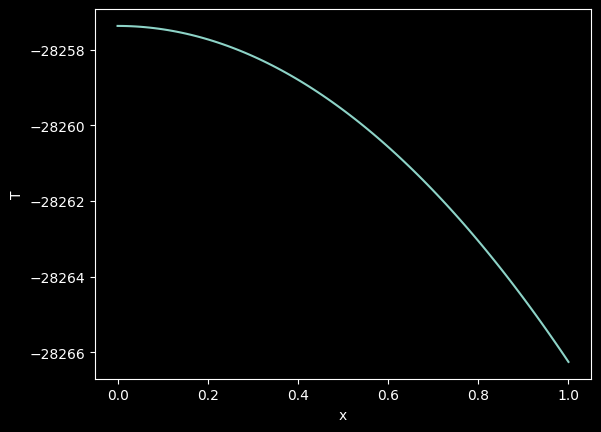

In [92]:
# T(x) = alpha*T_1(x) + Q*T_pl + beta*T_3(x) + Q*T_pu
def T(x):
    return alpha0*T_1(x) + Q*T_pl(x) + beta0*T_3(x) + Q*T_pu(x)

x_lst = np.linspace(0, 1, 100)
T_lst = [T(x) for x in x_lst]

plt.plot(x_lst, T_lst)
plt.xlabel('x')
plt.ylabel('T')
# plt.yscale('log')
plt.show()